In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


In [3]:
# Load dataset
file_path = "/kaggle/input/iot-final-dataset/IotFinalDataset.csv"
df = pd.read_csv(file_path)

# Define target column
target_column = 'Label'

# Encode target labels
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])

# Select features (all except target column)
features = [col for col in df.columns if col != target_column]

# Convert features to numeric (handle errors gracefully)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# Standardize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_column], test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training
batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data Preprocessing Done!")

Data Preprocessing Done!


In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, in_features):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.bn1 = nn.BatchNorm1d(in_features)
        self.fc2 = nn.Linear(in_features, in_features)
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        residual = x  # Store the original input
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        out += residual  # Add skip connection
        return F.relu(out)

class ResNetTabular(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ResNetTabular, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.res_block1 = ResNetBlock(128)
        self.res_block2 = ResNetBlock(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

# Initialize model
input_dim = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = ResNetTabular(input_dim, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("ResNet Model Initialized!")


ResNet Model Initialized!


In [5]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training Complete!")


Epoch 1/50, Loss: 0.1337
Epoch 2/50, Loss: 0.0521
Epoch 3/50, Loss: 0.0440
Epoch 4/50, Loss: 0.0407
Epoch 5/50, Loss: 0.0394
Epoch 6/50, Loss: 0.0380
Epoch 7/50, Loss: 0.0364
Epoch 8/50, Loss: 0.0349
Epoch 9/50, Loss: 0.0335
Epoch 10/50, Loss: 0.0336
Epoch 11/50, Loss: 0.0336
Epoch 12/50, Loss: 0.0335
Epoch 13/50, Loss: 0.0312
Epoch 14/50, Loss: 0.0300
Epoch 15/50, Loss: 0.0310
Epoch 16/50, Loss: 0.0299
Epoch 17/50, Loss: 0.0293
Epoch 18/50, Loss: 0.0290
Epoch 19/50, Loss: 0.0300
Epoch 20/50, Loss: 0.0286
Epoch 21/50, Loss: 0.0280
Epoch 22/50, Loss: 0.0276
Epoch 23/50, Loss: 0.0276
Epoch 24/50, Loss: 0.0267
Epoch 25/50, Loss: 0.0268
Epoch 26/50, Loss: 0.0268
Epoch 27/50, Loss: 0.0272
Epoch 28/50, Loss: 0.0257
Epoch 29/50, Loss: 0.0224
Epoch 30/50, Loss: 0.0199
Epoch 31/50, Loss: 0.0197
Epoch 32/50, Loss: 0.0205
Epoch 33/50, Loss: 0.0190
Epoch 34/50, Loss: 0.0183
Epoch 35/50, Loss: 0.0181
Epoch 36/50, Loss: 0.0191
Epoch 37/50, Loss: 0.0183
Epoch 38/50, Loss: 0.0183
Epoch 39/50, Loss: 0.

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_logits, dim=1).numpy()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.9772

Classification Report:
                    precision    recall  f1-score   support

            Benign       0.95      0.99      0.97     65391
         DNS Flood       1.00      0.84      0.91      9338
 Dictionary Attack       1.00      0.99      0.99      2013
        ICMP Flood       1.00      1.00      1.00     44930
           OS Scan       0.99      1.00      1.00      7700
        Ping Sweep       0.95      0.99      0.97     14358
         Port Scan       1.00      1.00      1.00     88162
         SYN Flood       0.99      0.05      0.09      2817
         Slowloris       1.00      1.00      1.00      3724
         UDP Flood       0.51      0.76      0.61      2015
Vulnerability Scan       1.00      1.00      1.00      8015

          accuracy                           0.98    248463
         macro avg       0.94      0.87      0.87    248463
      weighted avg       0.98      0.98      0.97    248463



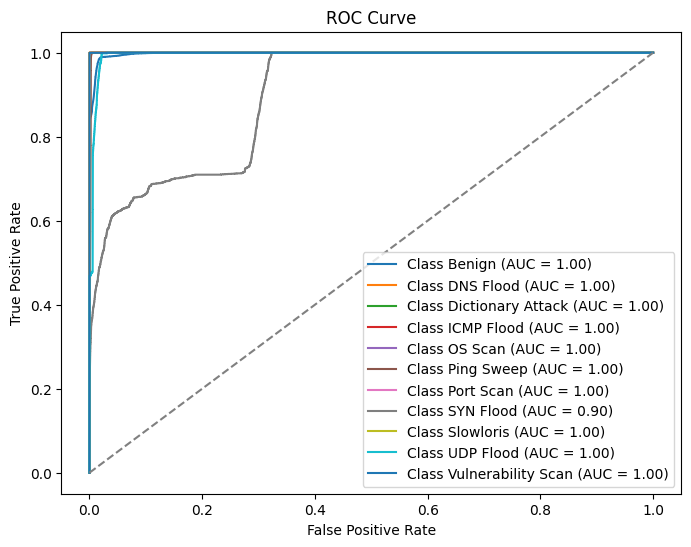

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


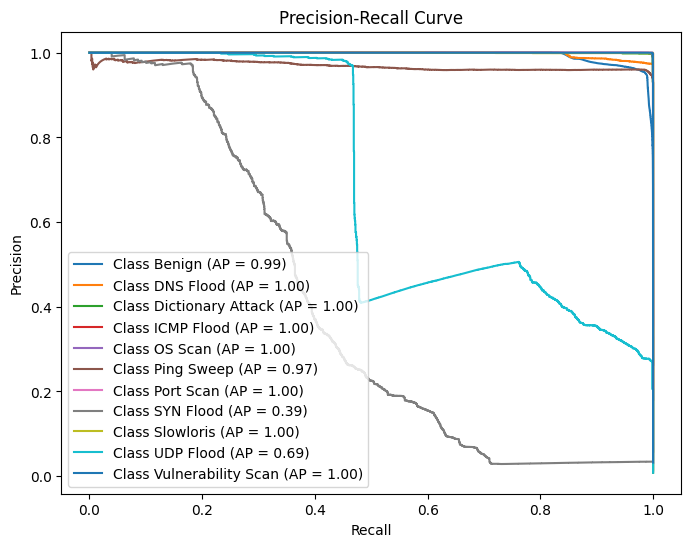

In [7]:
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
y_pred_proba = torch.softmax(y_pred_logits, dim=1).numpy()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]} (AP = {ap_score:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [8]:
# Save Model
torch.save(model.state_dict(), "resnet_tabular_model.pth")
joblib.dump(scaler, "scaler.pkl")
print("Model & Scaler Saved!")

# Load Model
model.load_state_dict(torch.load("resnet_tabular_model.pth"))
model.eval()
scaler = joblib.load("scaler.pkl")
print("Model & Scaler Loaded Successfully!")


Model & Scaler Saved!
Model & Scaler Loaded Successfully!


<ipython-input-8-254439d123c8>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_tabular_model.pth"))
